# Default of Credit Card Clients

## Using XGBoost in SageMaker

## Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.

In [1]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

  Using cached sagemaker-1.72.0-py2.py3-none-any.whl
  Using cached smdebug_rulesconfig-0.1.4-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.31.1
    Uninstalling sagemaker-2.31.1:
      Successfully uninstalled sagemaker-2.31.1


In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection

In addition to the modules above, we need to import the various bits of SageMaker that we will be using. 

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()
role = get_execution_role()

## Read the data

In [4]:
df = pd.read_csv('default-of-credit-card-clients.csv')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,female,university,married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,female,university,single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,female,university,single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,female,university,married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,male,university,married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
print("data shape: " + str(df.shape))

data shape: (30000, 25)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  int64 
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  object
 3   EDUCATION                   29669 non-null  object
 4   MARRIAGE                    29677 non-null  object
 5   AGE                         30000 non-null  int64 
 6   PAY_0                       30000 non-null  int64 
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

### remove duplicates

In [7]:
df.drop_duplicates(inplace=True)

### find the unique value for string featuers

In [8]:
print(df.SEX.unique())
print(df.EDUCATION.unique())
print(df.MARRIAGE.unique())

['female' 'male']
['university' 'graduate school' 'others' 'high school' nan '0']
['married' 'single' nan '0']


### fill strinf missing value with the mode value 

In [9]:
df.fillna(df.mode().iloc[0], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  int64 
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  int64 
 6   PAY_0                       30000 non-null  int64 
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

In [10]:
df.EDUCATION.replace({'0': str(df.EDUCATION.mode()[0])}, inplace=True)
df.MARRIAGE.replace({'0': str(df.MARRIAGE.mode()[0])}, inplace=True)

print(df.SEX.unique())
print(df.EDUCATION.unique())
print(df.MARRIAGE.unique())

['female' 'male']
['university' 'graduate school' 'others' 'high school']
['married' 'single']


### replace string data with numbers

In [11]:
df['SEX'].replace({'female': 0, 'male': 1}, inplace=True)
df['MARRIAGE'].replace({'married': 1, 'single': 0}, inplace=True)

### one hot encoding of columns education


In [12]:
one_hot = pd.get_dummies(df['EDUCATION'])
# Drop column education as it is now encoded
df.drop('EDUCATION',axis = 1, inplace=True)
# Join the encoded df
df = df.join(one_hot)
df.head()

,ID,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,graduate school,high school,others,university
0,1,20000,0,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,1,0,0,0,1
1,2,120000,0,0,26,-1,2,0,0,0,...,1000,1000,1000,0,2000,1,0,0,0,1
2,3,90000,0,0,34,0,0,0,0,0,...,1500,1000,1000,1000,5000,0,0,0,0,1
3,4,50000,0,1,37,0,0,0,0,0,...,2019,1200,1100,1069,1000,0,0,0,0,1
4,5,50000,1,1,57,-1,0,-1,0,0,...,36681,10000,9000,689,679,0,0,0,0,1


### rearange the colmuns

In [13]:
cols = list(df.columns.values)
cols

['ID',
 'LIMIT_BAL',
 'SEX',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'graduate school',
 'high school',
 'others',
 'university']

In [14]:
df = df[['ID',
 'LIMIT_BAL',
 'SEX',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'graduate school',
 'high school',
 'others',
 'university',
 'default payment next month']]

In [15]:
df.head()

,ID,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,graduate school,high school,others,university,default payment next month
0,1,20000,0,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,0,0,0,1,1
1,2,120000,0,0,26,-1,2,0,0,0,...,1000,1000,1000,0,2000,0,0,0,1,1
2,3,90000,0,0,34,0,0,0,0,0,...,1500,1000,1000,1000,5000,0,0,0,1,0
3,4,50000,0,1,37,0,0,0,0,0,...,2019,1200,1100,1069,1000,0,0,0,1,0
4,5,50000,1,1,57,-1,0,-1,0,0,...,36681,10000,9000,689,679,0,0,0,1,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [17]:
df.describe()

,ID,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,graduate school,high school,others,university,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,0.396267,0.455300,35.518833,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.352833,0.163867,0.004133,0.479167,0.221200
std,8660.398374,129747.661567,0.489129,0.498006,9.528019,1.123802,1.197186,1.196868,1.169139,1.133187,...,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.477859,0.370161,0.064159,0.499574,0.415062
min,1.000000,10000.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,0.000000,0.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.500000,140000.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22500.250000,240000.000000,1.000000,1.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,30000.000000,1000000.000000,1.000000,1.000000,267.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Viz Data

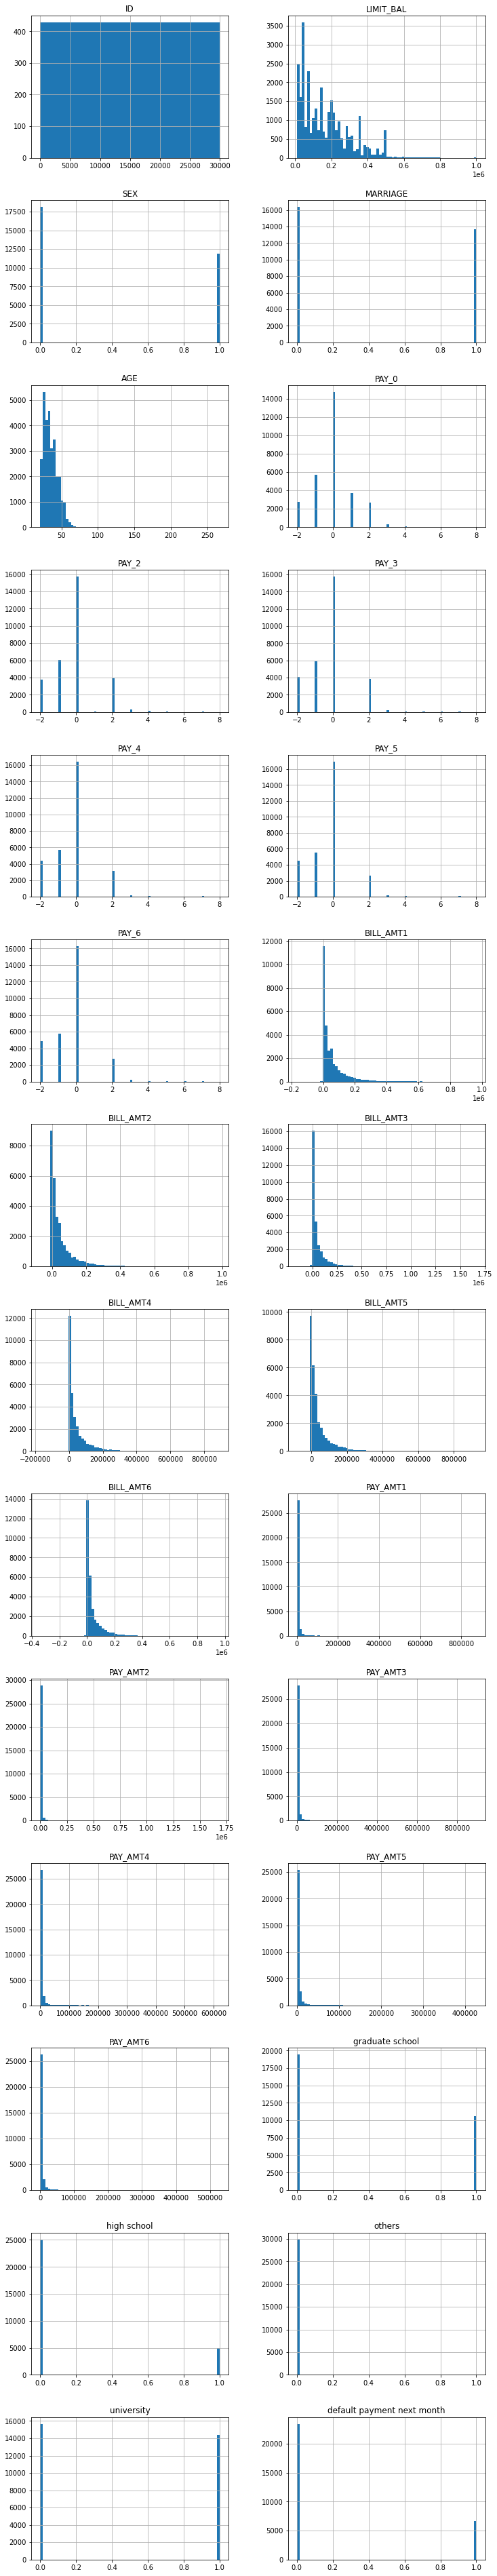

In [18]:
df.hist(layout=(14,2), figsize=(12,69), bins=70);

### find outliers 

In [19]:
df.query(" AGE > 100 or AGE < 18")

,ID,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,graduate school,high school,others,university,default payment next month
4011,4012,50000,1,0,149,0,0,0,0,0,...,2294,328,350,323,312,0,0,0,1,0
4116,4117,70000,0,0,126,0,0,0,0,0,...,2000,2000,2000,1000,2000,0,1,0,0,1
5395,5396,490000,0,1,152,-1,-1,-1,-1,-1,...,762,7000,0,4341,1061,0,0,0,1,0
6963,6964,470000,1,1,140,2,0,0,0,0,...,5214,4500,5000,4200,5000,1,0,0,0,1
7318,7319,360000,0,0,228,0,0,0,0,0,...,6059,5009,5021,5027,100017,1,0,0,0,0
8940,8941,200000,0,1,267,0,0,0,0,0,...,15019,15000,15000,10000,10000,0,1,0,0,0
29496,29497,80000,1,1,235,-1,-1,-1,-1,-1,...,1246,397,42860,7,118,0,0,0,1,0


### use Z score to find outliers  
 Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points.  
 These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used.  

In [20]:
from scipy import stats

z = np.abs(stats.zscore(df))
print(z)

[[1.73199307 1.13672015 0.81016074 ... 0.06442429 1.04257207 1.87637834]
 [1.7318776  0.3659805  0.81016074 ... 0.06442429 1.04257207 1.87637834]
 [1.73176213 0.59720239 0.81016074 ... 0.06442429 1.04257207 0.53294156]
 ...
 [1.73176213 1.05964618 1.23432296 ... 0.06442429 1.04257207 1.87637834]
 [1.7318776  0.67427636 1.23432296 ... 0.06442429 0.9591663  1.87637834]
 [1.73199307 0.90549825 1.23432296 ... 0.06442429 1.04257207 1.87637834]]


In [21]:
threshold = 4
print(np.where(z > threshold))
print(np.where(z > threshold)[0].shape[0])
print(np.where(z < -threshold))
print(np.where(z < -threshold)[0].shape[0])

(array([    6,     6,     6, ..., 29987, 29993, 29998]), array([11, 12, 13, ..., 19, 18, 17]))
4173
(array([], dtype=int64), array([], dtype=int64))
0


In [22]:
df_o = df[(z < threshold).all(axis=1)]
df_o.shape

(27842, 28)

In [23]:
df_o.describe()

,ID,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,graduate school,high school,others,university,default payment next month
count,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,...,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,27842.000000,27842.0,27842.000000,27842.000000
mean,14982.799332,157250.987716,0.391818,0.453631,35.400510,-0.024100,-0.141549,-0.180088,-0.241865,-0.288629,...,4188.569571,3636.642590,3312.068027,3282.472344,3343.312154,0.349400,0.166906,0.0,0.483694,0.224409
std,8651.545525,121645.443327,0.488165,0.497854,9.238047,1.080184,1.168243,1.157058,1.112430,1.080114,...,7911.969375,6748.613176,6380.638515,6256.900964,6888.526946,0.476789,0.372899,0.0,0.499743,0.417200
min,1.000000,10000.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,7493.250000,50000.000000,0.000000,0.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,780.000000,390.000000,247.250000,194.000000,5.250000,0.000000,0.000000,0.0,0.000000,0.000000
50%,14981.500000,130000.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2000.000000,1685.000000,1400.000000,1414.000000,1305.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,22464.750000,230000.000000,1.000000,1.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4647.750000,4000.000000,3616.500000,3601.000000,3502.000000,1.000000,0.000000,0.0,1.000000,0.000000
max,30000.000000,680000.000000,1.000000,1.000000,73.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,97472.000000,74934.000000,67296.000000,65862.000000,76220.000000,1.000000,1.000000,0.0,1.000000,1.000000


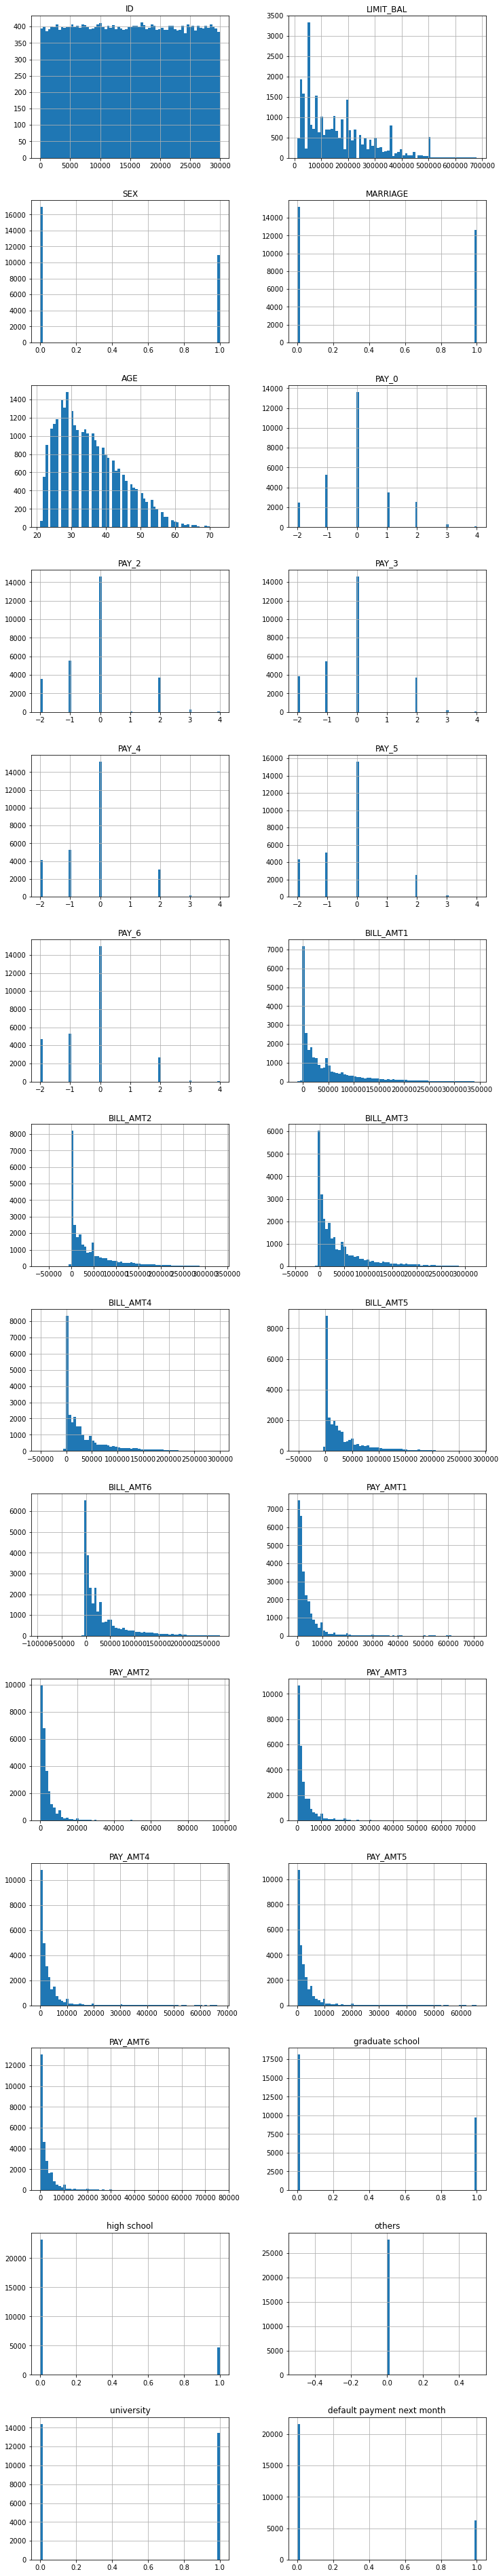

In [24]:
df_o.hist(layout=(14,2), figsize=(12,69), bins=70);

### find high corr features

In [25]:
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
print(numeric_features)

['ID', 'LIMIT_BAL', 'SEX', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'graduate school', 'high school', 'others', 'university', 'default payment next month']


Text(0.5, 1.0, 'dataset correlation')

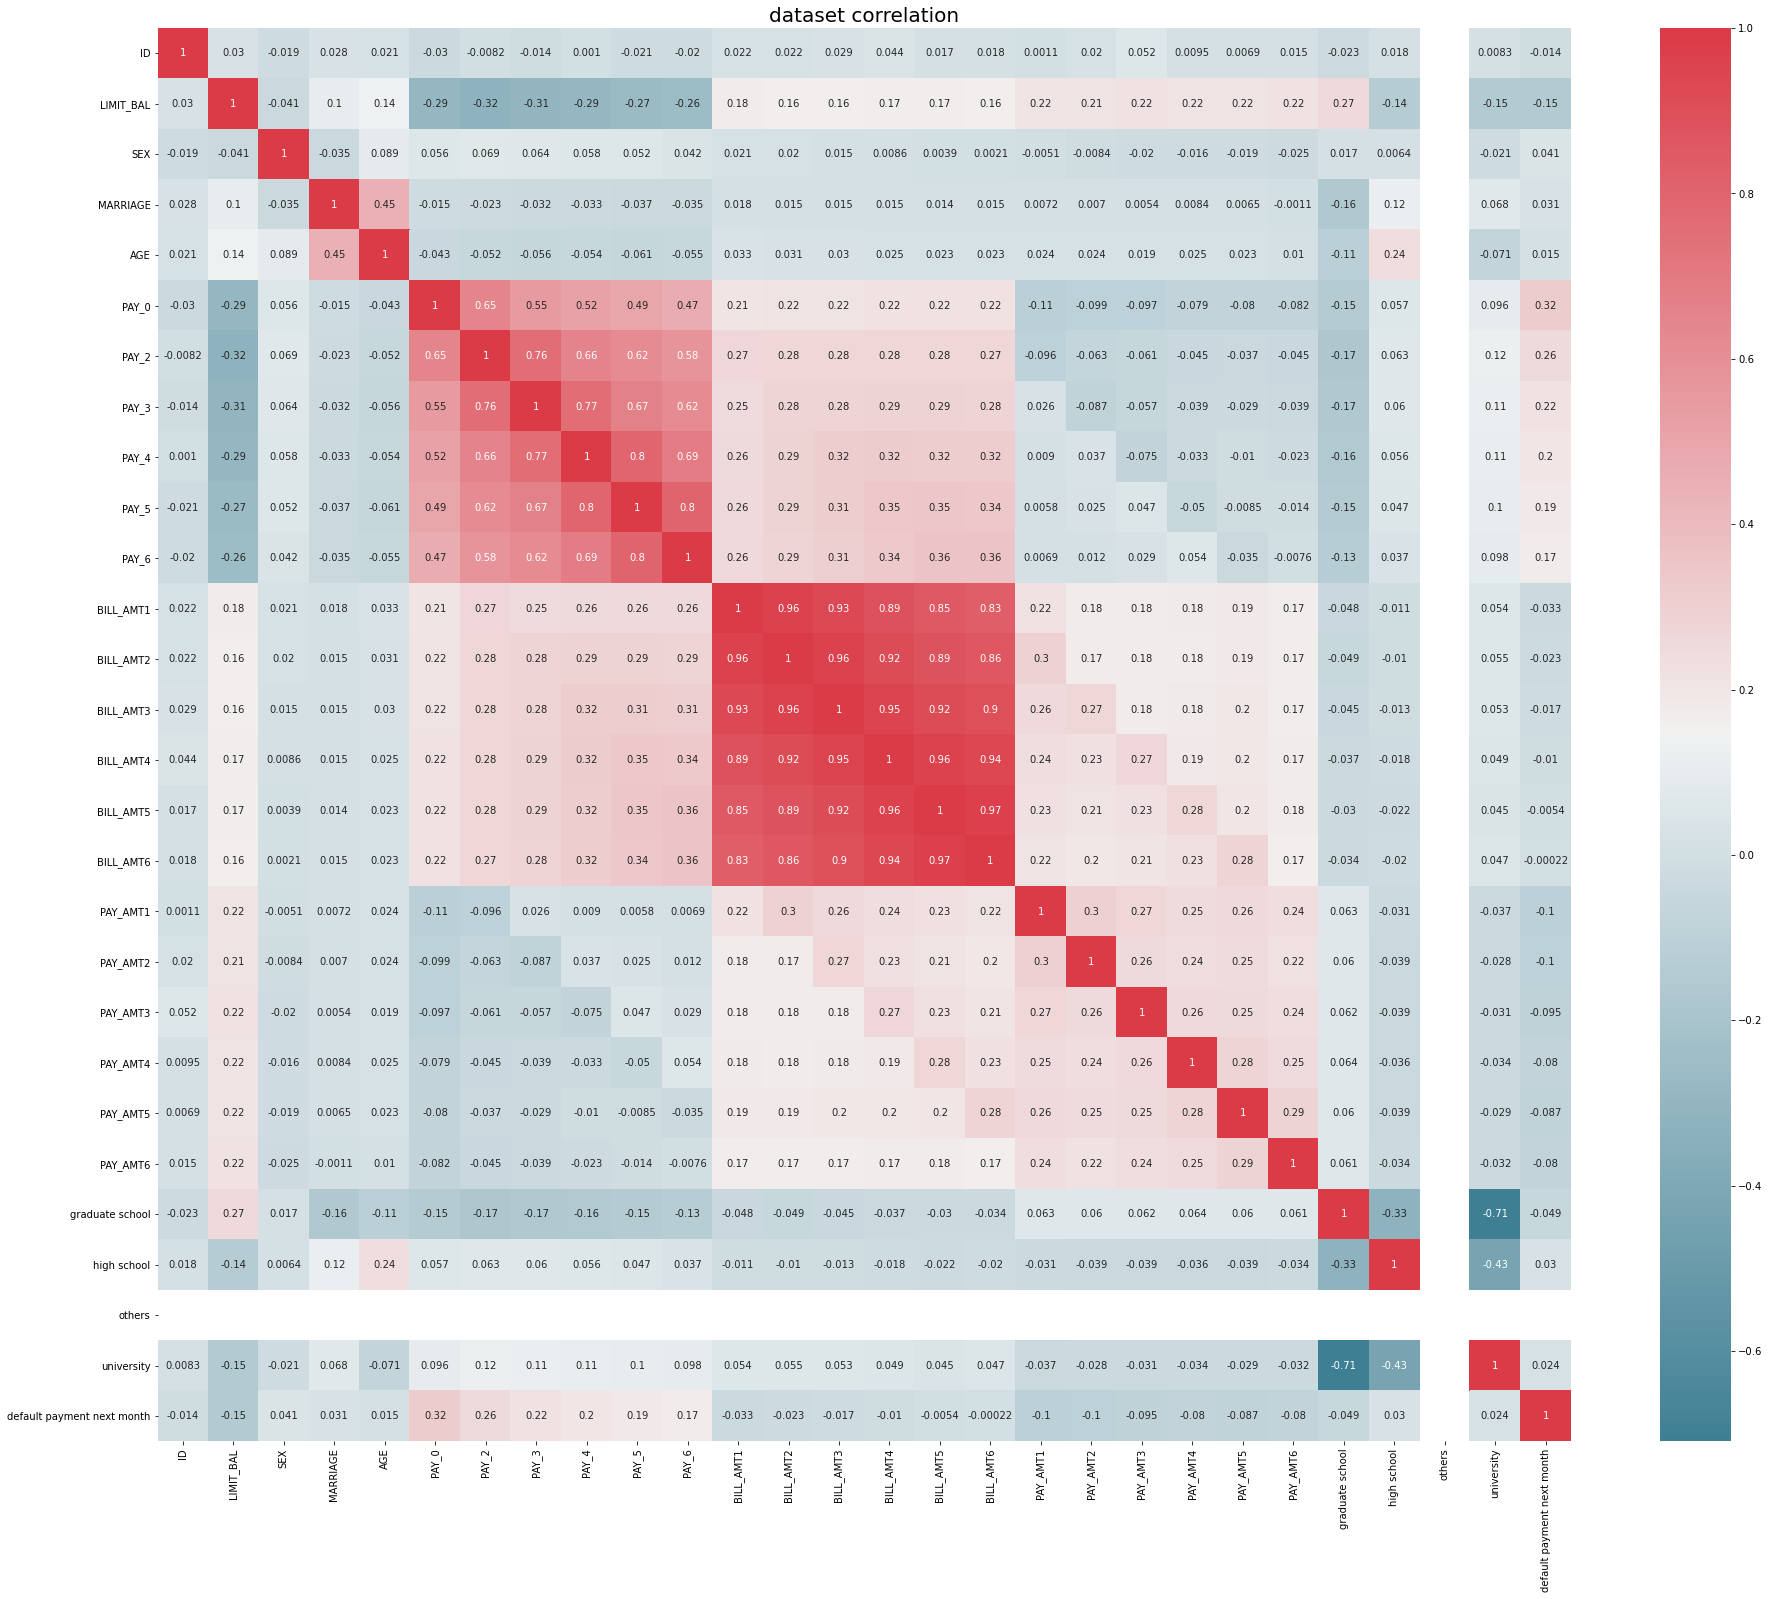

In [26]:
import seaborn as sns

f, ax = plt.subplots(figsize=(32, 26))
corr = df_o[numeric_features].corr()
mp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)
mp.set_title(label='dataset correlation', fontsize=20)

In [27]:
# Create correlation matrix
corr_matrix = df_o.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df_o.drop(to_drop, axis=1, inplace=True)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
df_o.head()

,ID,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,graduate school,high school,others,university,default payment next month
0,1,20000,0,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,0,0,0,1,1
1,2,120000,0,0,26,-1,2,0,0,0,...,1000,1000,1000,0,2000,0,0,0,1,1
2,3,90000,0,0,34,0,0,0,0,0,...,1500,1000,1000,1000,5000,0,0,0,1,0
3,4,50000,0,1,37,0,0,0,0,0,...,2019,1200,1100,1069,1000,0,0,0,1,0
4,5,50000,1,1,57,-1,0,-1,0,0,...,36681,10000,9000,689,679,0,0,0,1,0


### drop unused colmuns

In [29]:
df_o.drop(columns=['ID'], inplace=True)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27842 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   27842 non-null  int64
 1   SEX                         27842 non-null  int64
 2   MARRIAGE                    27842 non-null  int64
 3   AGE                         27842 non-null  int64
 4   PAY_0                       27842 non-null  int64
 5   PAY_2                       27842 non-null  int64
 6   PAY_3                       27842 non-null  int64
 7   PAY_4                       27842 non-null  int64
 8   PAY_5                       27842 non-null  int64
 9   PAY_6                       27842 non-null  int64
 10  BILL_AMT1                   27842 non-null  int64
 11  PAY_AMT1                    27842 non-null  int64
 12  PAY_AMT2                    27842 non-null  int64
 13  PAY_AMT3                    27842 non-null  int64
 14  PAY_AM

### normlize data

In [31]:
from sklearn import preprocessing

x = df_o.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_n = pd.DataFrame(x_scaled)

In [32]:
df_n.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.014925,0.0,1.0,0.057692,0.666667,0.666667,0.166667,0.166667,0.000000,0.000000,...,0.007069,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0
1,0.164179,0.0,0.0,0.096154,0.166667,0.666667,0.333333,0.333333,0.333333,0.666667,...,0.010259,0.013345,0.014860,0.000000,0.026240,0.0,0.0,0.0,1.0,1.0
2,0.119403,0.0,0.0,0.250000,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,...,0.015389,0.013345,0.014860,0.015183,0.065600,0.0,0.0,0.0,1.0,0.0
3,0.059701,0.0,1.0,0.307692,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,...,0.020714,0.016014,0.016346,0.016231,0.013120,0.0,0.0,0.0,1.0,0.0
4,0.059701,1.0,1.0,0.692308,0.166667,0.333333,0.166667,0.333333,0.333333,0.333333,...,0.376323,0.133451,0.133738,0.010461,0.008908,0.0,0.0,0.0,1.0,0.0


## Step 2: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

In [33]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_n, test_size=0.2, shuffle=True, random_state=23)
val_data, test_data = train_test_split(test_data, test_size=0.2, shuffle=True, random_state=23)

In [34]:
y_train = train_data[21]
X_train = train_data[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

In [35]:
y_test = test_data[21]
X_test = test_data[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

In [36]:
y_val = val_data[21]
X_val = val_data[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

## Uploading the data files to S3

When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details.

### Save the data locally

First we need to create the test, train and validation csv files which we will then upload to S3.

In [37]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [38]:
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload to S3

Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket. Note that it is good practice to provide a custom prefix (essentially an S3 folder) to make sure that you don't accidentally interfere with data uploaded from some other notebook or project.

In [39]:
prefix = 'case1-xgboost-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Train the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. We will be making use of the high level SageMaker API to do this which will make the resulting code a little easier to read at the cost of some flexibility.

In [91]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Before asking SageMaker to begin the training job, we should probably set any model specific hyperparameters. There are quite a few that can be set when using the XGBoost algorithm, below are just a few of them. If you would like to change the hyperparameters below or modify additional ones you can find additional information on the [XGBoost hyperparameter page](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

In [92]:
xgb.set_hyperparameters(max_depth=10,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=1,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric='auc',
                        num_round=200)

Now that we have our estimator object completely set up, it is time to train it. To do this we make sure that SageMaker knows our input data is in csv format and then execute the `fit` method.

In [93]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-04-01 08:30:05 Starting - Starting the training job...
2021-04-01 08:30:06 Starting - Launching requested ML instances......
2021-04-01 08:31:17 Starting - Preparing the instances for training......
2021-04-01 08:32:28 Downloading - Downloading input data...
2021-04-01 08:32:58 Training - Downloading the training image...
2021-04-01 08:33:30 Uploading - Uploading generated training modelArguments: train
[2021-04-01:08:33:20:INFO] Running standalone xgboost training.
[2021-04-01:08:33:20:INFO] File size need to be processed in the node: 7.36mb. Available memory size in the node: 8421.31mb
[2021-04-01:08:33:20:INFO] Determined delimiter of CSV input is ','
[08:33:20] S3DistributionType set as FullyReplicated
[08:33:20] 22273x21 matrix with 467733 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-04-01:08:33:20:INFO] Determined delimiter of CSV input is ','
[08:33:20] S3DistributionType set as FullyReplicated
[08:33:20] 4455x21 matrix with 93555


2021-04-01 08:33:37 Completed - Training job completed
Training seconds: 69
Billable seconds: 69


## Test the model

Now that we have fit our model to the training data, using the validation data to avoid overfitting, we can test our model. To do this we will make use of SageMaker's Batch Transform functionality. To start with, we need to build a transformer object from our fit model.

In [94]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Next we ask SageMaker to begin a batch transform job using our trained model and applying it to the test data we previously stored in S3.

In [95]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [96]:
xgb_transformer.wait()

.............................Arguments: serve
[2021-04-01 08:38:56 +0000] [1] [INFO] Starting gunicorn 19.9.0
Arguments: serve
[2021-04-01 08:38:56 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-04-01 08:38:56 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-04-01 08:38:56 +0000] [1] [INFO] Using worker: gevent
[2021-04-01 08:38:56 +0000] [20] [INFO] Booting worker with pid: 20
[2021-04-01 08:38:56 +0000] [21] [INFO] Booting worker with pid: 21
[2021-04-01 08:38:56 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/u

Now that the batch transform job has finished, the resulting output is stored on S3. Since we wish to analyze the output inside of our notebook we can use a bit of notebook magic to copy the output file from its S3 location and save it locally.

In [97]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-893054581338/xgboost-2021-04-01-08-34-17-967/test.csv.out to ../data/test.csv.out


To see how well our model works we can create a simple scatter plot between the predicted and actual values. If the model was completely accurate the resulting scatter plot would look like the line $x=y$. As we can see, our model seems to have done okay but there is room for improvement.

In [98]:
y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [99]:
preds =  y_pred > 0.5
preds = pred.astype(int)

Accuracy: 0.8186714542190305
Precision: 0.7457627118644068
Recall: 0.3384615384615385


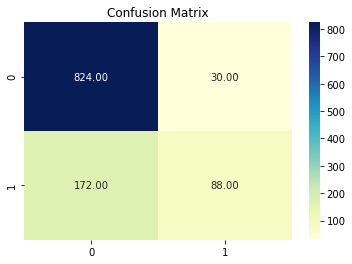

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_test, preds)
print(f'Precision: {precision}')

# Calculate recall
recall = recall_score(y_test, preds)
print(f'Recall: {recall}')

confusion_matrix = confusion_matrix(y_test, preds)
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix'); 

## Clean up



In [101]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir